<a href="https://colab.research.google.com/github/sjdoescoding/CE889/blob/main/individual_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
'''Code adapted from
https://heartbeat.comet.ml/building-a-neural-network-from-scratch-using-python-part-1-6d399df8d432
'''

'Code adapted from\nhttps://heartbeat.comet.ml/building-a-neural-network-from-scratch-using-python-part-1-6d399df8d432\n'

In [12]:
# Importing Libraries 

import numpy as np
from numpy import save
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# Connecting Google Drive
# from zipfile import ZipFile
  
from google.colab import drive #mounting to drive
drive.mount('/content/drive', force_remount=True)


df = pd.read_csv('/content/drive/MyDrive/CE889/ce889_dataCollection.csv')

Mounted at /content/drive


In [13]:
# df.rename(columns = {'X':'X_dist', 'Y':'y_dist','Z':'X_vel','': 'y_vel'}, inplace = True)

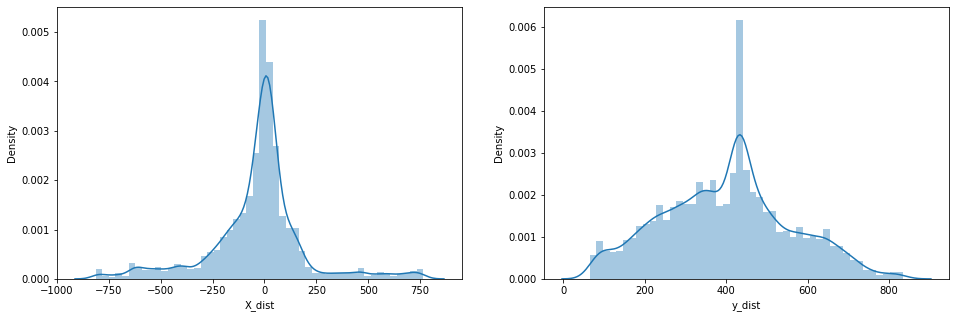

In [14]:
# X & Y Distance Distributions
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df['X_dist'])
plt.subplot(1,2,2)
sns.distplot(df['y_dist'])
plt.show()

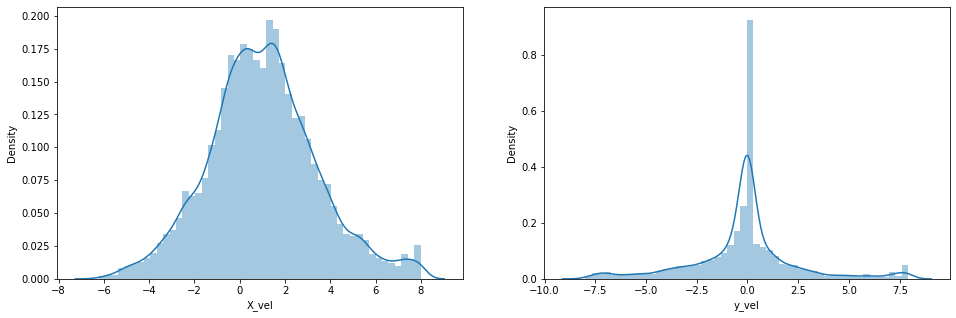

In [15]:
# X & Y Velocity Distributions
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df['X_vel'])
plt.subplot(1,2,2)
sns.distplot(df['y_vel'])
plt.show()

The data is mostly normally distributed with no significant outliers.

In [16]:
# Assigning the inputs and target to a 2d df
X = df[['X_dist','y_dist']]
y = df[['X_vel', 'y_vel']]

In [17]:
# Scaling the data and normalizing it into 0-1 range
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

In [18]:
# Splitting the data into test train splits for a better accuracy.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [19]:
# Neural Network Architecture
class NeuralNet():       
    def __init__(self, layers=[2,3,2], learning_rate=1e-4, iterations=1000):
        self.params = {} # For layers and Weight assignment
        self.learning_rate = learning_rate #learning rate
        self.iterations = iterations # epochs
        self.loss = [] # For plotting loss and taking RMSE score
        self.layers = layers
        self.X = None
        self.y = None

    #Initializing Weights for the model 
    def init_weights(self):
        np.random.seed(1) # Seed the random number generator
        self.params["W1"] = np.random.randn(self.layers[0], self.layers[1]) 
        self.params['b1'] = np.random.randn(self.layers[1],)
        self.params['W2'] = np.random.randn(self.layers[1],self.layers[2]) 
        self.params['b2'] = np.random.randn(self.layers[2],)           

    #sigmoid activation function 
    def sigmoid(self,Z):
        return 1/(1+np.exp(-Z))

    #deriv of sigmoid for updating weights and parameters
    def dsigmoid(self, Z):
        return self.sigmoid(Z) * (1 - self.sigmoid(Z))

    #stepwise stopping criteria
    def eta(self, x):
      ETA = 0.0000000001
      return np.maximum(x, ETA)

    #RMSE Training function for learning
    def root_mean_squared_error(self, y, yhat):
      diff = yhat - y
      differences_squared = diff ** 2
      mean_diff = differences_squared.mean()
      loss = np.sqrt(mean_diff)
      return loss 

    #feedforward model
    # Taking X input, then pass it through hidden layer multiplied by weights to output layer
    def forward_propagation(self):
        

        Z1 = self.X.dot(self.params['W1']) + self.params['b1'] #input
        A1 = self.sigmoid(Z1) #activation/hidden
        Z2 = A1.dot(self.params['W2']) + self.params['b2'] 
        yhat = self.sigmoid(Z2)
        loss = self.root_mean_squared_error(self.y,yhat)

        # save calculated parameters     
        self.params['Z1'] = Z1
        self.params['Z2'] = Z2
        self.params['A1'] = A1

        return yhat,loss

    #computes the derivatives and updates weights and bias
    # Calculating output error and delak weights and update the output weights
    # delta(h^i) and hidden weights are updated
    # Loop until weights stabilise and error is small
    def back_propagation(self,yhat):
  
        y_inv = 1 - self.y
        yhat_inv = 1 - yhat

        dl_error = np.divide(y_inv, self.eta(yhat_inv)) - np.divide(self.y, self.eta(yhat)) 
        dl_error_sig = yhat * (yhat_inv)
        dl_error_z2 = dl_error * dl_error_sig

        dl_error_A1 = dl_error_z2.dot(self.params['W2'].T) 
        dl_error_w2 = self.params['A1'].T.dot(dl_error_z2)
        dl_error_b2 = np.sum(dl_error_z2, axis=0, keepdims=True)

        dl_error_z1 = dl_error_A1 * self.dsigmoid(self.params['Z1'])
        dl_error_w1 = self.X.T.dot(dl_error_z1)
        dl_error_b1 = np.sum(dl_error_z1, axis=0, keepdims=True)

        #update the weights and bias
        self.params['W1'] = self.params['W1'] - self.learning_rate * dl_error_w1
        self.params['W2'] = self.params['W2'] - self.learning_rate * dl_error_w2
        self.params['b1'] = self.params['b1'] - self.learning_rate * dl_error_b1
        self.params['b2'] = self.params['b2'] - self.learning_rate * dl_error_b2



    #training the model 
    def fit(self, X, y):

        self.X = X
        self.y = y
        self.init_weights() #initialize weights and bias

        for i in range(self.iterations):
            yhat, loss = self.forward_propagation()
            self.back_propagation(yhat)
            self.loss.append(loss)


    def predict(self, X):
        '''
        Predicts on a test data
        '''
        Z1 = X.dot(self.params['W1']) + self.params['b1']
        A1 = self.sigmoid(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        pred = self.sigmoid(Z2)
        return pred


    def acc(self, y, yhat):
        acc = np.square(np.subtract(y, yhat)).mean()
        acc = np.sqrt(acc)
        return acc


    def plot_loss(self):
        '''
        Plots the loss curve
        '''
        plt.plot(self.loss)
        plt.xlabel("Iteration")
        plt.ylabel("logloss")
        plt.title("Loss curve for training")
        plt.show()  

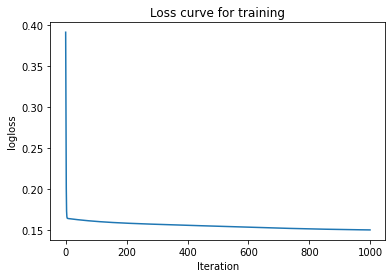

In [20]:
# Plotting loss for trainset
nn = NeuralNet() # create the NN model
nn.fit(X_train, y_train) #train the model
nn.plot_loss()

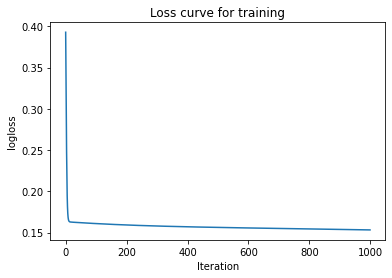

In [21]:
# Plotting loss for test set
nn = NeuralNet() # create the NN model
nn.fit(X_test, y_test) #train the model
nn.plot_loss()

In [22]:
train_pred = nn.predict(X_train)
test_pred = nn.predict(X_test)

print("Train accuracy is {}".format(nn.acc(y_train, train_pred)))
print("Test accuracy is {}".format(nn.acc(y_test, test_pred)))

Train accuracy is 0.15475580858498472
Test accuracy is 0.15319152778836687


In [23]:
prediction = nn.predict(y)

In [24]:
df1 = pd.DataFrame(prediction, columns =['X_vel_pred','Y_vel_pred'])

In [25]:
df1

,X_vel_pred,Y_vel_pred
0,0.481546,0.477112
1,0.482056,0.478329
2,0.484103,0.480100
3,0.484607,0.481302
4,0.486638,0.483051
...,...,...
16350,0.498883,0.497462
16351,0.498166,0.496260
16352,0.495955,0.494531
16353,0.495227,0.493312
